# Corregir imágenes de Borini

El siguiente código intenta entender los errores principales derivados del cálculo de las estadísticas pre y pos fuego.


In [1]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
from matplotlib import pyplot as plt

In [2]:
ROOT_PAF = Path(r"D:\doctorado_iranzo\lineas\paf")
ROOT_BOR = Path("H:/Borini/harmoPAF/HarmoPAF_time_series")
logs_path = Path(ROOT_PAF, "results/year_classifications/logs.txt")
fires_path = Path(ROOT_PAF, "data/raw/perimetros/PUFsar_WGS84.shp")
# The bounding box of each Borini's tiles
tiles_path = Path(ROOT_BOR, "tiles_perimeters/tiles_perimeters.gpkg")

In [23]:
logs_colnames = ["date_time", "IDPAF", "borini_tile", "log"]
logs = pd.read_csv(logs_path, sep="\t", names=logs_colnames)
print("Mensajes de error mas comunes:")
logs["log"].value_counts()

Mensajes de error mas comunes:


log
Init to compute fire                                                        161
Metadata consistency check failed: Rasters must have the same transform.     94
Abort.                                                                       67
Fire is already computed. Skipping.                                          35
No data in year 1985. Abort.                                                 16
An error occurred: Input shapes do not overlap raster.                       14
Pos fire composite missing year.                                             12
Cls and prob products created.                                               10
There is no pre year available.                                               7
No data in year 2012. Abort.                                                  3
No data in year 2004. Abort.                                                  2
No data in year 1996. Abort.                                                  1
Name: count, dtype: int64

## Metadata consistency check failed: Rasters must have the same transform.

En principio, este error se genera por una mala alineación de las imágenes dentro de un tile. A continuación:

1. Cargar imágenes dentro de los tiles afectados.
2. Recopilar su información de metadatos.
3. Transformar todas ellas a un único tipo de transformación y BBOX.

In [25]:
err_msg = "Metadata consistency check failed: Rasters must have the same transform."
err_idpafs = pd.unique(logs.query(f"log == '{err_msg}'")["IDPAF"])
print(f"Incendios dentro de tiles con error de extensión (n {len(err_idpafs)}):")
err_idpafs

Incendios dentro de tiles con error de extensión (n 48):


array([123,  72,  73,  84,  97,  89, 122, 131, 134, 128, 133,  87, 132,
       120, 115, 135, 177, 179,  99, 113, 129, 109, 184, 190, 176, 171,
       165, 167, 157, 151, 169, 158, 163, 160, 161, 147, 182, 187, 188,
       191, 192, 201, 199, 202, 195, 196, 194, 197], dtype=int64)

In [26]:
err_tiles = pd.unique(logs.query(f"log == '{err_msg}'")["borini_tile"])
print(f"Tiles con error de extensión (n {len(err_tiles)}):")
err_tiles

Tiles con error de extensión (n 19):


array(['p5', 'p12', 'p4', 'p8_2', 'p6', 'p3', 'p7_2', 'p21', 'p20', 'p25',
       'p23', 'p7_4', 'p1_2', 'p24', 'p7_3', 'p19_3', 'p16', 'p11_2',
       'p19_2'], dtype=object)

### Detectar las dimensiones más pequeñas

Las coordenadas de un raster se guardan en el objeto `rasterio` de la siguiente forma:

```python
raster.bounds
# BoundingBox(left=623115.0, bottom=4566615.0, right=679065.0, top=4591365.0)
```

In [7]:
class Tile:
  
    def __init__(self, root_path, tile_folder):
        """
        Iterate through all images inside a tile folder.
        Crop all bounding boxes to the image with:
        - The smallest bbox.
        - It bbox is inside all the rest of the images.
        """
        # Construct the path to retrieve the images inside the tile folder
        self.root = Path(root_path, tile_folder, "5_Harmonized")

    def _get_metadata(self, raster_path):
        """Get rasterio properties."""
        with rasterio.open(raster_path) as src:
            return (src.meta, src.bounds)
          
    def save_metadata(self):
        """Save rasterio metadata of the images inside the tile."""
        # Empty dict. to store image paths and their metadata
        metadata_dict = {}
        
        for img_path in self.root.glob("*.tif"):
            img_name = img_path.name
            # Get rasterio image metadata
            meta, bounds = self._get_metadata(img_path)
            metadata_dict[img_name] = [meta, bounds, img_path]
        
        self.metadata = metadata_dict

In [46]:
tile_p5 = Tile(ROOT_BOR, "p5")
tile_p5.save_metadata()

Encontrar las imágenes con diferente BBOX dentro de un tile.

In [18]:
def compute_distinct_bboxs(tile_obj):
    distinct_bbox = []
    distinct_imgname = []
    for img_name, [_, img_bounds, img_folder] in tile_obj.metadata.items():
        if len(distinct_bbox) == 0:
            distinct_bbox.append(img_bounds)
            distinct_imgname.append(img_name)
        else:
            if img_bounds not in distinct_bbox:
                distinct_bbox.append(img_bounds)
                distinct_imgname.append(img_name)
    return (distinct_bbox, distinct_imgname)

A continuación se muestran dos BBOX distintos entre sí. La diferencia es tan pequeña que debe mostrarse cada una de las esquinas individualmente para poder apreciar la diferencia. A pesar de ello, al calcular estadísticas entre ellos obtendremos un error de extensión.

In [47]:
distinct_bbox, distinct_imgname = compute_distinct_bboxs(tile_p5)
print("Tienen el mismo BBOX?:", distinct_bbox[1] == distinct_bbox[20])

Tienen el mismo BBOX?: False


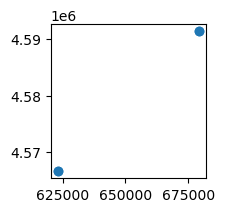

In [93]:
bbox1 = distinct_bbox[1]
bbox2 = distinct_bbox[20]
y = [bbox1.bottom, bbox1.top, bbox2.bottom, bbox2.top]
x = [bbox1.left, bbox1.right, bbox2.left, bbox2.right]
plt.scatter(x, y)
fig = plt.gcf()
fig.set_size_inches(2, 2)

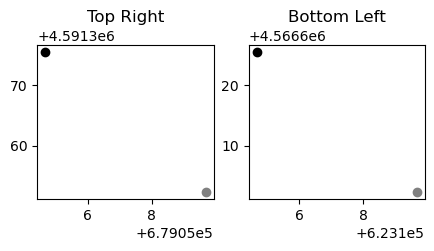

In [94]:
xs = [bbox1.right, bbox2.right, bbox1.left, bbox2.left]
ys = [bbox1.top, bbox2.top, bbox1.bottom, bbox2.bottom]

fig, axs = plt.subplots(1, 2, figsize=(5, 2))

colors = ["black", "grey", "black", "grey"]
count = 0
for x, y, c in zip(xs, ys, colors):
    
    if count < 2:
        axs[0].scatter(x, y, color=c)
        axs[0].set_title("Top Right")
    else:
        axs[1].scatter(x, y, color=c)
        axs[1].set_title("Bottom Left")

    count += 1


El siguiente código necesita encontrar la BBOX cuya área se incluya en la BBOX más grande. Se utilizará para recortar el raster con la mayor dimensión.

Siendo $W$ y $H$ la anchura y altura del BBOX con mayor tamaño, y $w$ y $h$ las del BBOX más pequeño, se debe de cumplir la siguiente condición para poder afirmar que una BBOX entra dentro de otra BBOX:

$$(w * h) < (W * H)$$

La anchura y la altura se calculan de la siguiente forma:

$$Width = BBOX_{right} - BBOX_{left}$$
$$Height = BBOX_{top} - BBOX_{bottom}$$

Método a seguir:

1. Asignar aleatoriamente una BBOX como la más reducida.
2. Comprobar si está dentro de la segunda BBOX.
3. Si está dentro, la primera BBOX será la más pequeña y la que se usará para recortar a la segunda imagen.
4. Por el contrario, será la segunda BBOX la más pequeña.

In [96]:
def is_smallest(bbox, small_bbox):
    # Compute the width and height of the bboxes.
    w_bbox = bbox.right - bbox.left
    h_bbox = bbox.top - bbox.bottom
    w_sbbox = small_bbox.right - small_bbox.left
    h_sbbox = small_bbox.top - small_bbox.bottom
    # Apply the theorem to check if the bbox is inside the small_bbox
    # (w * h) < (W * H)
    print(w_bbox, h_bbox)
    print(w_sbbox, h_sbbox)
    return (w_bbox * h_bbox) < (w_sbbox * h_sbbox)

In [97]:
is_smallest(bbox1, bbox2)

55950.0 24750.0
55950.0 24750.0


False

Problema: Las imágenes de Borini parecen tener un patrón en el desplazamiento. Tienen la misma anchura y la misma altura, pero están desplazadas unos pocos metros (menos de un píxel landsat, unos 23 metros approx.)

Es por ello que no pueden recortarse, pues no hay ninguna que contenga al resto.

### Solución

Las imágenes se recortan por tres AOIs distintos:

1. En el proceso de extracción de puntos, por el AOI de los puntos que caigan en el tile (totalmente contenidos dentro).
2. En el proceso de extracción de métricas, por el AOI del incendio.
3. Generar una nueva BBOX con la intersección de todos los BBOX.

#### Generar intersección

To find the intersection of three bounding boxes (B1, B2, and B3), you need to determine the overlapping region by taking:

- **Maximum of the left (min X) coordinates**: `left = max(B1.left, B2.left, B3.left)`
- **Minimum of the right (max X) coordinates**: `right = min(B1.right, B2.right, B3.right)`
- **Maximum of the bottom (min Y) coordinates**: `bottom = max(B1.bottom, B2.bottom, B3.bottom)`
- **Minimum of the top (max Y) coordinates**: `top = min(B1.top, B2.top, B3.top)`

If `left < right` and `bottom < top`, then the intersection exists, and the resulting bounding box is:

If the result is `None`, it means there is no intersection between the three bounding boxes.

In [12]:
def intersect_bboxes(bboxes):
    left = max(b[0] for b in bboxes)
    bottom = max(b[1] for b in bboxes)
    right = min(b[2] for b in bboxes)
    top = min(b[3] for b in bboxes)

    if left < right and bottom < top:
        return (left, bottom, right, top)  # Valid intersection
    else:
        return None  # No intersection

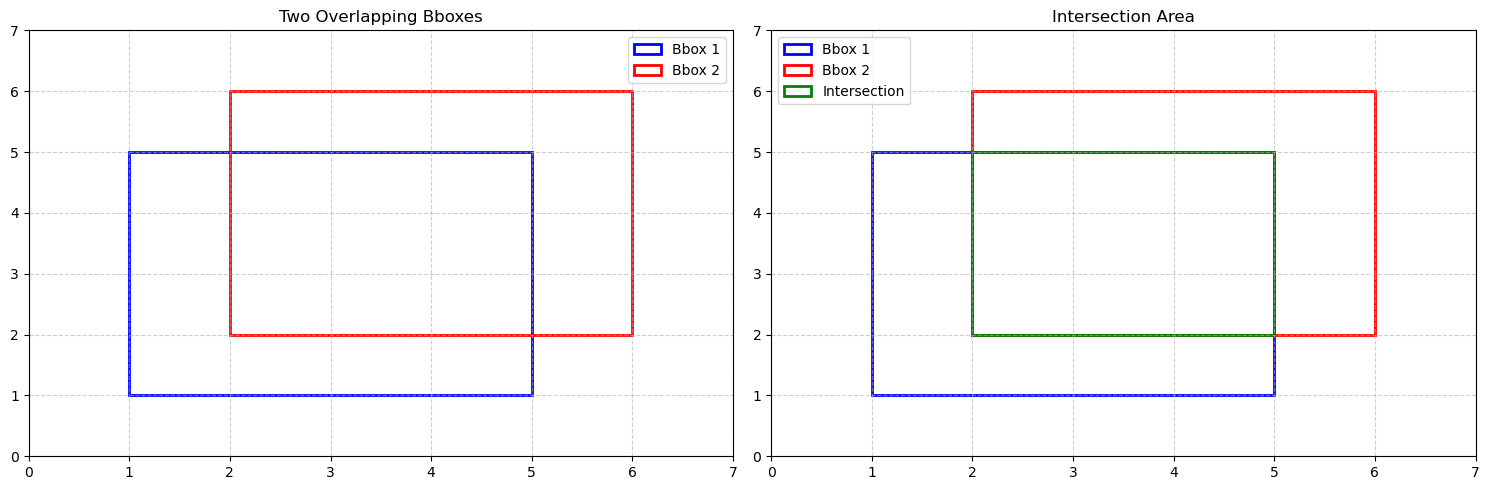

In [15]:
import matplotlib.patches as patches

# Define bounding boxes (left, bottom, right, top)
bbox1 = (1, 1, 5, 5)  # First bounding box
bbox2 = (2, 2, 6, 6)  # Second bounding box, slightly shifted
# bbox3 = (3, 3, 4, 4)  # Third bounding box, intersecting both

# Compute intersection of all three bounding boxes
intersection = intersect_bboxes([bbox1, bbox2])

# Function to plot bounding boxes
def plot_bboxes(ax, bboxes, colors, labels, title):
    ax.set_xlim(0, 7)
    ax.set_ylim(0, 7)
    ax.set_xticks(range(8))
    ax.set_yticks(range(8))
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_title(title)

    for bbox, color, label in zip(bboxes, colors, labels):
        rect = patches.Rectangle(
            (bbox[0], bbox[1]),  # Bottom-left corner
            bbox[2] - bbox[0],   # Width
            bbox[3] - bbox[1],   # Height
            linewidth=2,
            edgecolor=color,
            facecolor='none',
            label=label
        )
        ax.add_patch(rect)
    
    ax.legend()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Two bounding boxes
plot_bboxes(axes[0], [bbox1, bbox2], ["blue", "red"], ["Bbox 1", "Bbox 2"], "Two Overlapping Bboxes")

# Plot 2: Adding the third bounding box
# plot_bboxes(axes[1], [bbox1, bbox2, bbox3], ["blue", "red", "green"], ["Bbox 1", "Bbox 2", "Bbox 3"], "Three Bounding Boxes")

# Plot 3: Highlighting the intersection
if intersection:
    plot_bboxes(axes[1], [bbox1, bbox2, intersection], ["blue", "red", "green"], ["Bbox 1", "Bbox 2", "Intersection"], "Intersection Area")

plt.tight_layout()
plt.show()


In [48]:
intersection = intersect_bboxes(distinct_bbox)
print(intersection)

(623231.7763030765, 4566722.733005807, 679021.2254459112, 4591342.630806461)


In [55]:
tile_p5.metadata[distinct_imgname[0]][0]['crs'].to_epsg()
# tile_p5.metadata['19840319_199031_L05_BOA_GEOM_BRDF_TOPO_SPECtoL8.tif']

32630

In [59]:
import json

# Function to convert bounding box to GeoJSON format
def bbox_to_geojson(bbox, crs_epsg):
    if bbox is None:
        return None  # No intersection
    
    left, bottom, right, top = bbox
    geojson = {
        "type": "FeatureCollection",
        "crs": {
            "type": "name",
            "properties": {
                "name": f"EPSG:{crs_epsg}"
            }
        },
        "features": [
            {
                "type": "Feature",
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [[
                        [left, bottom], [right, bottom],
                        [right, top], [left, top],
                        [left, bottom]  # Closing the polygon
                    ]]
                },
                "properties": {"name": "Intersection Area"}
            }
        ]
    }

    return geojson

def export_geojson(output_path, crs_epsg):
    # Convert intersection bbox to GeoJSON
    intersection_geojson = bbox_to_geojson(intersection, crs_epsg)
    
    # Export to a file
    if intersection_geojson:
        geojson_filename = Path(output_path, "intersect_bbox.geojson")
        with open(geojson_filename, "w") as f:
            json.dump(intersection_geojson, f, indent=4)
    else:
        print("No intersection found, so no GeoJSON file was created.")

A continuación, se generan las áreas de intersección para cada tile con BBOX diferentes.

In [60]:
for tile in err_tiles:
    print("Compute tile ", tile)
    tile_obj = Tile(ROOT_BOR, tile)
    tile_obj.save_metadata()

    distinct_bbox, distinct_imgname = compute_distinct_bboxs(tile_obj)
    # All the tiles have the same CRS
    crs_epsg = tile_obj.metadata[distinct_imgname[0]][0]['crs'].to_epsg()
    intersection = intersect_bboxes(distinct_bbox)
    export_geojson(tile_obj.root, crs_epsg)

Compute tile  p5
Compute tile  p12
Compute tile  p4
Compute tile  p8_2
Compute tile  p6
Compute tile  p3
Compute tile  p7_2
Compute tile  p21
Compute tile  p20
Compute tile  p25
Compute tile  p23
Compute tile  p7_4
Compute tile  p1_2
Compute tile  p24
Compute tile  p7_3
Compute tile  p19_3
Compute tile  p16
Compute tile  p11_2
Compute tile  p19_2


## An error occurred: Input shapes do not overlap raster.

Esto pasa con algunos incendios, asociados con determinados tiles pero que en la práctica parece que no lo cumplen (pues no es posible su extracción). 

In [39]:
err_msg = "An error occurred: Input shapes do not overlap raster."
err_idpafs = pd.unique(logs.query(f"log == '{err_msg}'")["IDPAF"])
print("Incendios con problemas de adscripción a un tile de Borini:")
err_idpafs

Incendios con problemas de adscripción a un tile de Borini:


array([80, 70, 88], dtype=int64)

In [22]:
# Load fire perimeters
fires = gpd.read_file(fires_path).to_crs(32630)
fires = fires.astype({'Year': np.int16})
# Filter fires by year
fires = fires.query("Year >= 1988")

# Open the bounding box of each Borini tile
tile_aois = gpd.read_file(tiles_path)

# Get the IDPAFs inside (fully contained) each tile
tile_aois_idpaf = gpd.sjoin(fires, tile_aois, predicate='within')

Buscar los incendios con problemas y ver realmente si su BBOX está totalmente dentro de un tile de Borini.

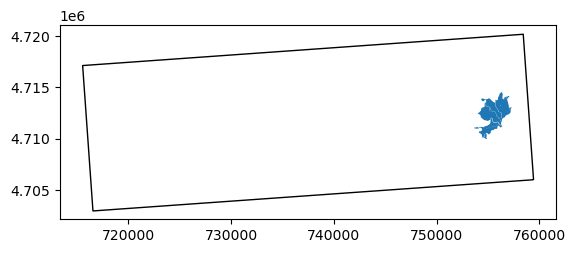

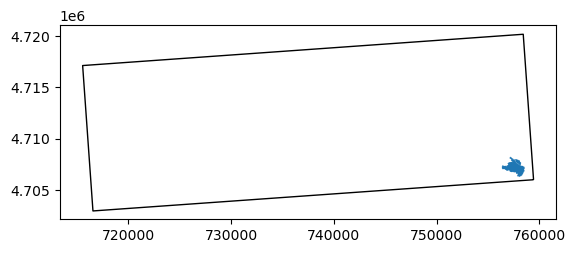

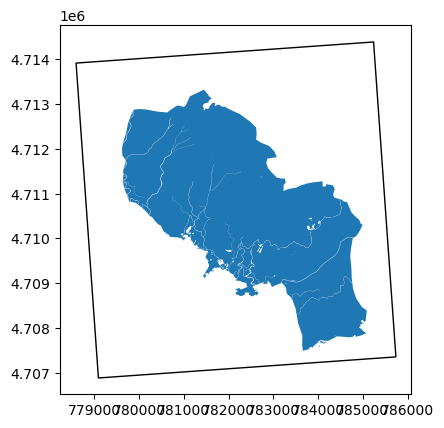

In [ ]:
for idpaf in err_idpafs:
    # Get the Borini tile which fully contains current fire
    id_tile = tile_aois_idpaf.query(f"IDPAF == {idpaf}")["name"].to_list()[0]

    base = tile_aois.query(f"name == '{id_tile}'").plot(color="white", edgecolor="black")
    fires.query(f"IDPAF == {idpaf}").plot(ax=base)

Todos los incendios están contenidos por completo en un tile. Entonces, ¿por qué devuelve un error?